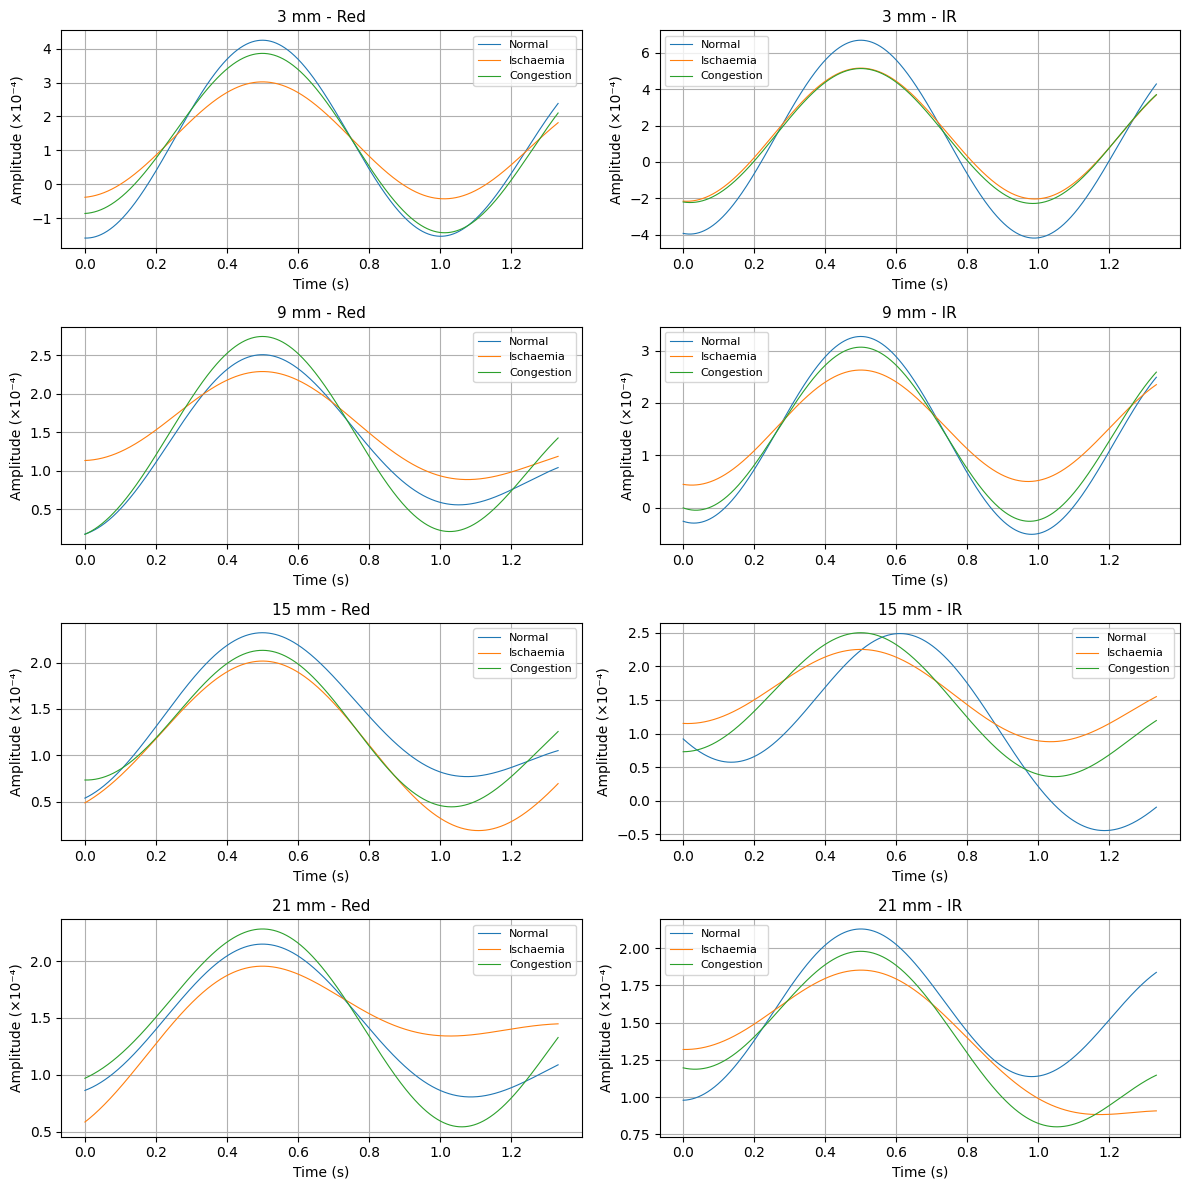

In [ ]:
#PPG波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 2          # 表示時間 [秒]
start_search = 3      # 検索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1":"Normal","data2":"Ischaemia","data3":"Congestion"}
channels = {"ppgA_Red_raw":"Red", "ppgA_IR_raw":"IR"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=1.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 12), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ch_label) in enumerate(channels.items()):
        ax = axes[i_depth, j_ch]

        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # --- AC/DC正規化 ---
            dc = butter_lowpass_filter(sig, fs, cutoff=0.5)
            sig_norm = (sig - dc) / (dc + 1e-8)

            # --- 強スムージング ---
            smoothed = butter_lowpass_filter(sig_norm, fs, cutoff=1.0)

            # --- 開始5秒以降の最大値（ピーク）を検出 ---
            start_idx = int(start_search * fs)
            if start_idx >= len(smoothed):
                start_idx = 0
            max_idx = np.argmax(smoothed[start_idx:]) + start_idx

            # --- 表示区間（ピーク中心 → 前にずらす） ---
            view_len = int(view_sec * fs)
            pre_offset = int(view_len * 0.25)  # ピークから0.75秒前に開始
            start_plot = max(max_idx - pre_offset, 0)
            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            # --- 表示は先頭2/3まで ---
            cut_len = int(view_len * 2 / 3)
            seg = smoothed[start_plot:start_plot + cut_len]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg * 1e4, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ch_label}", fontsize=11)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude (×10⁻⁴)")
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

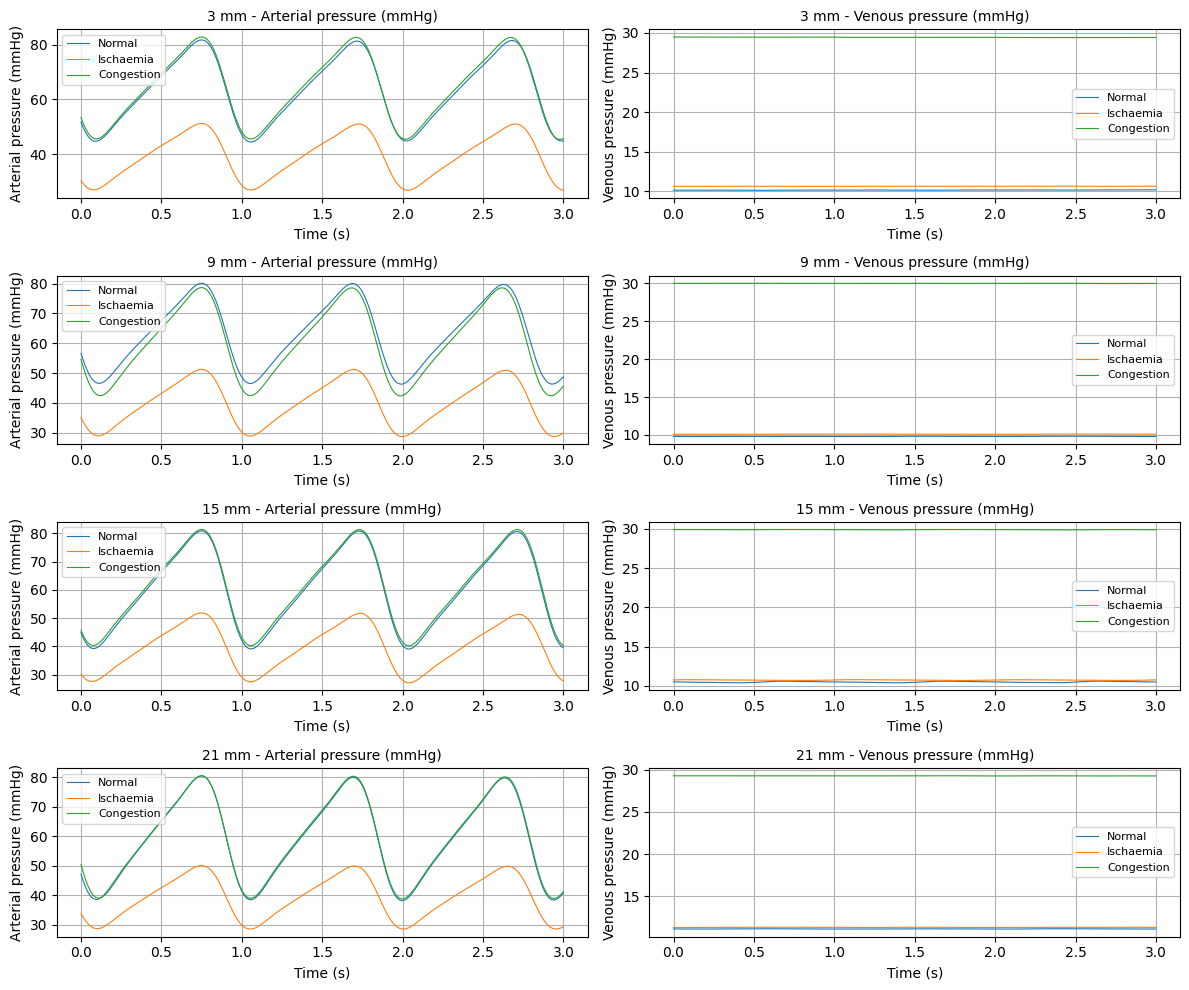

In [ ]:
#圧力波形の表示

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# ===== パラメータ =====
fs = 2000             # サンプリング周波数 [Hz]
view_sec = 3          # 表示時間 [秒]
start_search = 5      # ピーク探索開始時間 [秒]
depths = [3, 9, 15, 21]
state_map = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
pressure_channels = {"p2_mmhg": "Arterial pressure (mmHg)", "p1_mmhg": "Venous pressure (mmHg)"}

# ===== バタワース低域通過フィルタ =====
def butter_lowpass_filter(sig, fs, cutoff=3.0, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low')
    return filtfilt(b, a, sig)

# ===== 図の準備 =====
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 10), sharex=False, sharey=False)
axes = axes.reshape(4, 2)

for i_depth, depth in enumerate(depths):
    for j_ch, (col_name, ylabel) in enumerate(pressure_channels.items()):
        ax = axes[i_depth, j_ch]
        for state_key, state_name in state_map.items():
            file = f"{depth}mm_adjusted_{state_key}.csv"
            try:
                df = pd.read_csv(file)
            except FileNotFoundError:
                print(f"⚠️ {file} が見つかりません")
                continue

            if col_name not in df.columns:
                print(f"⚠️ {file} に {col_name} がありません")
                continue

            sig = df[col_name].dropna().values
            if len(sig) < fs * (start_search + view_sec):
                print(f"⚠️ {file} の信号が短すぎます")
                continue

            # スムージング
            smoothed = butter_lowpass_filter(sig, fs, cutoff=3.0)

            # 表示区間の決定
            view_len = int(view_sec * fs)
            start_idx = int(start_search * fs)

            if col_name == "p2_mmhg":  # 動脈 → ピーク揃え
                max_idx = np.argmax(smoothed[start_idx:]) + start_idx
                pre_offset = int(view_len * 0.25)
                start_plot = max(max_idx - pre_offset, 0)
            else:  # 静脈 → 一律スタート
                start_plot = start_idx

            end_plot = start_plot + view_len
            if end_plot > len(smoothed):
                end_plot = len(smoothed)
                start_plot = max(end_plot - view_len, 0)

            seg = smoothed[start_plot:end_plot]
            t = np.arange(len(seg)) / fs

            ax.plot(t, seg, label=state_name, linewidth=0.8)

        ax.set_title(f"{depth} mm - {ylabel}", fontsize=10)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel(ylabel)
        ax.grid(True)
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
#AGC処理とcsv生成

import pandas as pd
import numpy as np
from pathlib import Path

# ========= パラメータ =========
fs = 2000             # サンプリング周波数
target_amp = 1.0      # AGC後の目標振幅
gain_limit = (0.1,10) # AGCゲインの上下限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ========= AGC 関数 =========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    """一定区間ごとにAGCをかけて振幅をそろえる"""
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg)==0: continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ========= 全ファイル処理 =========
for depth in depths:
    for i_state, state_name in state_map.items():
        input_file = f"{depth}mm_adjusted_data{i_state}.csv"
        output_file = f"{depth}mm_AGC_data{i_state}.csv"
        
        # ファイル読み込み
        df = pd.read_csv(input_file)
        if not {"ppgA_Red_raw","ppgA_IR_raw"}.issubset(df.columns):
            print(f"[警告] {input_file} に必要な列がありません")
            continue

        # AGC適用
        df["ppgA_Red_AGC"] = apply_agc(df["ppgA_Red_raw"].values, fs, 1, target_amp, gain_limit)
        df["ppgA_IR_AGC"]  = apply_agc(df["ppgA_IR_raw"].values,  fs, 1, target_amp, gain_limit)

        # 保存
        df.to_csv(output_file, index=False)
        print(f"[保存完了] {output_file}")


[保存完了] 3mm_AGC_data1.csv
[保存完了] 3mm_AGC_data2.csv
[保存完了] 3mm_AGC_data3.csv
[保存完了] 9mm_AGC_data1.csv
[保存完了] 9mm_AGC_data2.csv
[保存完了] 9mm_AGC_data3.csv
[保存完了] 15mm_AGC_data1.csv
[保存完了] 15mm_AGC_data2.csv
[保存完了] 15mm_AGC_data3.csv
[保存完了] 21mm_AGC_data1.csv
[保存完了] 21mm_AGC_data2.csv
[保存完了] 21mm_AGC_data3.csv


In [ ]:
#SQI計算とcsv生成

import pandas as pd
import numpy as np
from pathlib import Path
from scipy.signal import savgol_filter, correlate
from scipy.fft import rfft, rfftfreq

# ===== パラメータ =====
fs = 2000              # サンプリング周波数 [Hz]
target_amp = 1.0       # AGC後の目標振幅
window_sec = 8         # SQI評価窓の長さ [秒]
gain_limit = (0.1, 10) # AGCゲインの制限
depths = [3, 9, 15, 21]
state_map = {1: "Normal", 2: "Ischaemia", 3: "Congestion"}

# ======== AGC 関数 ========
def apply_agc(signal, fs, window_sec=1.0, target_amp=1.0, gain_limit=(0.1,10.0)):
    step = int(window_sec * fs)
    out = np.zeros_like(signal, dtype=float)
    for start in range(0, len(signal), step):
        end = min(start+step, len(signal))
        seg = signal[start:end]
        if len(seg) == 0:
            continue
        rms = np.sqrt(np.mean(seg**2))
        gain = target_amp / (rms + 1e-8)
        gain = np.clip(gain, gain_limit[0], gain_limit[1])
        out[start:end] = seg * gain
    return out

# ======== SQI 関数 ========
def compute_sqi(segment, fs):
    if len(segment) < fs:
        return np.nan
    # --- 1. 振幅対雑音比 ---
    amp = segment.max() - segment.min()
    noise = np.std(segment)
    snr = amp / (noise + 1e-8)
    snr_norm = min(snr/10, 1)

    # --- 2. 自己相関 (周期性) ---
    corr = correlate(segment - np.mean(segment), segment - np.mean(segment), mode='full')
    corr = corr[len(corr)//2:]
    corr = corr / (np.max(corr)+1e-8)
    lag_min = int(0.5*fs)
    lag_max = int(1.5*fs)
    if lag_max >= len(corr):
        lag_max = len(corr)-1
    ac_peak = np.max(corr[lag_min:lag_max]) if lag_max>lag_min else 0
    ac_norm = np.clip(ac_peak, 0, 1)

    # --- 3. 周波数ドミナンス ---
    freqs = rfftfreq(len(segment), 1/fs)
    fft_vals = np.abs(rfft(segment))
    mask = (freqs>0.5) & (freqs<3)
    if not np.any(mask):
        return np.nan
    band_power = fft_vals[mask]
    peak = np.max(band_power)
    total = np.sum(band_power)
    dom = peak / (total+1e-8)
    dom_norm = np.clip(dom*5, 0, 1)

    # 総合SQI
    return np.mean([snr_norm, ac_norm, dom_norm])

# ===== SQI計算 =====
records = []

for depth in depths:
    for i_state, state_name in state_map.items():
        file = Path(f"{depth}mm_AGC_data{i_state}.csv")
        if not file.exists():
            print(f"[警告] {file} が存在しません")
            continue

        df = pd.read_csv(file)

        for ch in ["ppgA_Red_AGC", "ppgA_IR_AGC"]:
            sig = savgol_filter(df[ch].values, 51, 3)

            # window_sec ごとに SQI 計算
            step = int(window_sec * fs)
            sqis = []
            for start in range(0, len(sig)-step, step):
                seg = sig[start:start+step]
                sqi_val = compute_sqi(seg, fs)
                sqis.append(sqi_val)

            mean_sqi = np.nanmean(sqis)
            std_sqi = np.nanstd(sqis)
            valid_ratio = np.mean(~np.isnan(sqis))

            records.append({
                "Depth": depth,
                "Condition": state_name,
                "Channel": "Red" if "Red" in ch else "IR",
                "SQI_mean": mean_sqi,
                "SQI_std": std_sqi,
                "Valid_ratio": valid_ratio,
                "n_windows": len(sqis)
            })

# ===== 結果を保存 =====
df_sqi = pd.DataFrame(records)
df_sqi.to_csv("SQI_summary.csv", index=False)
print("✅ SQI_summary.csv を出力しました")
print(df_sqi.round(3))

✅ SQI_summary.csv を出力しました
    Depth   Condition Channel  SQI_mean  SQI_std  Valid_ratio  n_windows
0       3      Normal     Red     0.751    0.001          1.0          3
1       3      Normal      IR     0.735    0.002          1.0          3
2       3   Ischaemia     Red     0.752    0.002          1.0          3
3       3   Ischaemia      IR     0.736    0.001          1.0          3
4       3  Congestion     Red     0.749    0.003          1.0          3
5       3  Congestion      IR     0.738    0.000          1.0          3
6       9      Normal     Red     0.639    0.016          1.0          3
7       9      Normal      IR     0.743    0.000          1.0          3
8       9   Ischaemia     Red     0.666    0.023          1.0          3
9       9   Ischaemia      IR     0.748    0.002          1.0          3
10      9  Congestion     Red     0.701    0.030          1.0          3
11      9  Congestion      IR     0.741    0.001          1.0          3
12     15      Normal    

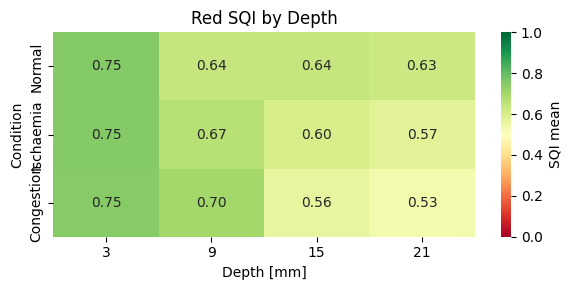

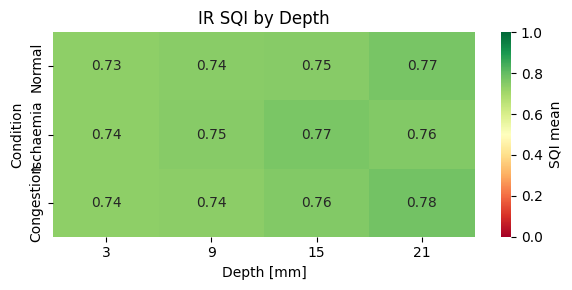

In [ ]:
#SQIヒートマップの描画

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== SQI 集計結果の読み込み =====
df_sqi = pd.read_csv("SQI_summary.csv")

# ===== Red と IR に分ける =====
df_red = df_sqi[df_sqi["Channel"] == "Red"]
df_ir  = df_sqi[df_sqi["Channel"] == "IR"]

# ===== Pivotしてヒートマップ用の表を作成 =====
red_pivot = df_red.pivot(index="Condition", columns="Depth", values="SQI_mean")
ir_pivot  = df_ir.pivot(index="Condition", columns="Depth", values="SQI_mean")

# Condition の表示順を統一
order = ["Normal", "Ischaemia", "Congestion"]
red_pivot = red_pivot.reindex(order)
ir_pivot  = ir_pivot.reindex(order)

# ===== ヒートマップ描画 =====
def plot_sqi_heatmap(data, title):
    plt.figure(figsize=(6,3))
    sns.heatmap(
        data,
        annot=True, fmt=".2f",
        cmap="RdYlGn", center=0.5,  # 0.5 を基準色に
        vmin=0, vmax=1,             # SQI の範囲を 0〜1 に固定
        cbar_kws={"label": "SQI mean"}
    )
    plt.title(title)
    plt.xlabel("Depth [mm]")
    plt.ylabel("Condition")
    plt.tight_layout()
    plt.show()

plot_sqi_heatmap(red_pivot, "Red SQI by Depth")
plot_sqi_heatmap(ir_pivot,  "IR SQI by Depth")

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

# ===== パラメータ =====
depths = [3, 9, 15, 21]
group_names = ["Normal", "Ischaemia", "Congestion"]

# ===== 結果格納用リスト =====
results = []

# ===== 各深さについてKruskal-Wallis検定 =====
for depth in depths:
    # ファイル読み込み（AGC済みデータを使用）
    files = [
        (f"{depth}mm_AGC_data1.csv", "Normal"),
        (f"{depth}mm_AGC_data2.csv", "Ischaemia"),
        (f"{depth}mm_AGC_data3.csv", "Congestion"),
    ]

    red_groups = []
    ir_groups = []
    
    for file, _ in files:
        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].values
        ir = df["ppgA_IR_AGC"].values

        # 窓ごとの振幅（最大-最小）
        fs = 2000
        window_sec = 1
        step = fs * window_sec
        n_win = len(red) // step

        red_amp = []
        ir_amp = []
        for w in range(n_win):
            s = w * step
            e = s + step
            rseg = red[s:e]
            iseg = ir[s:e]
            if len(rseg) < 2 or len(iseg) < 2:
                continue
            red_amp.append(rseg.max() - rseg.min())
            ir_amp.append(iseg.max() - iseg.min())

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # 正規化（IR Normalの平均 = 0.5に）
    normal_ir_mean = np.mean(ir_groups[0])
    scale_factor = 0.5 / normal_ir_mean
    red_groups_scaled = [[v * scale_factor for v in g] for g in red_groups]
    ir_groups_scaled  = [[v * scale_factor for v in g] for g in ir_groups]

    # Kruskal-Wallis検定
    stat_red, p_red = kruskal(*red_groups_scaled)
    stat_ir,  p_ir  = kruskal(*ir_groups_scaled)

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "Red",
        "Chi-Squared": stat_red,
        "df": len(red_groups_scaled)-1,
        "p-Value": p_red
    })

    results.append({
        "Depth": f"{depth}mm",
        "Channel": "IR",
        "Chi-Squared": stat_ir,
        "df": len(ir_groups_scaled)-1,
        "p-Value": p_ir
    })

# ===== 結果の保存 =====
df_result = pd.DataFrame(results)
df_result.to_csv("KW_result.csv", index=False)

# ===== 結果の表示 =====
print("✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):")
print(df_result.round(4))


✅ Kruskal-Wallis 検定の結果 (Chi², df, p-value):
  Depth Channel  Chi-Squared  df  p-Value
0   3mm     Red      59.8612   2   0.0000
1   3mm      IR      71.5815   2   0.0000
2   9mm     Red      35.9352   2   0.0000
3   9mm      IR      61.9042   2   0.0000
4  15mm     Red       9.1090   2   0.0105
5  15mm      IR      65.0099   2   0.0000
6  21mm     Red      23.7721   2   0.0000
7  21mm      IR      53.1963   2   0.0000


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata, norm
import os

# ===== パラメータ =====
fs = 2000
window_sec = 1
depths = [3, 9, 15, 21]
states = {"data1": "Normal", "data2": "Ischaemia", "data3": "Congestion"}
group_names = list(states.values())

# ===== Dunn test関数 =====
def dunn_test(groups, group_labels):
    data = np.concatenate(groups)
    groups_id = np.concatenate([[i]*len(g) for i, g in enumerate(groups)])
    ranks = rankdata(data)
    n = len(data)
    ties_correction = 1 - (np.sum(np.bincount(ranks.astype(int))[1:]**3 - np.bincount(ranks.astype(int))[1:]) / (n**3 - n))
    if ties_correction <= 0: ties_correction = 1

    n_i = [len(g) for g in groups]
    R_i = [np.sum(ranks[groups_id==i]) for i in range(len(groups))]
    mean_rank_i = [R_i[i]/n_i[i] for i in range(len(groups))]

    results = []
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            diff = mean_rank_i[i] - mean_rank_i[j]
            SE = np.sqrt((n*(n+1)/12) * (1/n_i[i] + 1/n_i[j]) * ties_correction)
            Z = diff / SE
            p = 2 * (1 - norm.cdf(abs(Z)))  # 両側
            results.append({
                "Comparison": f"{group_labels[i]} vs {group_labels[j]}",
                "Z": Z,
                "p_Unadj": p
            })

    df = pd.DataFrame(results)
    df["p_Adj"] = np.minimum(df["p_Unadj"] * len(df), 1.0)
    return df

# ===== 結果格納用 =====
all_results = []

for depth in depths:
    red_groups = []
    ir_groups = []

    for data_key in states:
        file = f"{depth}mm_AGC_{data_key}.csv"
        if not os.path.exists(file):
            print(f"⚠️ File not found: {file}")
            continue

        df = pd.read_csv(file)
        red = df["ppgA_Red_AGC"].dropna().values
        ir  = df["ppgA_IR_AGC"].dropna().values

        step = int(fs * window_sec)
        red_amp = [(red[i:i+step].max() - red[i:i+step].min())
                   for i in range(0, len(red) - step, step)]
        ir_amp = [(ir[i:i+step].max() - ir[i:i+step].min())
                  for i in range(0, len(ir) - step, step)]

        red_groups.append(red_amp)
        ir_groups.append(ir_amp)

    # ========== Dunn検定 (Red) ==========
    df_dunn_red = dunn_test(red_groups, group_names)
    df_dunn_red.insert(1, "Channel", "Red")
    df_dunn_red.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_red)

    # ========== Dunn検定 (IR) ==========
    df_dunn_ir = dunn_test(ir_groups, group_names)
    df_dunn_ir.insert(1, "Channel", "IR")
    df_dunn_ir.insert(2, "Depth", f"{depth}mm")
    all_results.append(df_dunn_ir)

# ===== 結果統合・保存 =====
df_all = pd.concat(all_results, ignore_index=True)
df_all = df_all[["Comparison", "Channel", "Depth", "Z", "p_Unadj", "p_Adj"]]
df_all = df_all.rename(columns={
    "p_Unadj": "p (Unadjusted)",
    "p_Adj": "p (Adjusted)"
})

# 表示
print("\n=== Dunn post-hoc test results across all depths ===")
print(df_all.round(4))

# 保存
df_all.to_csv("dunn_posthoc_all_depths.csv", index=False)
print("\n✅ Dunn test results saved to 'dunn_posthoc_all_depths.csv'")



=== Dunn post-hoc test results across all depths ===
                 Comparison Channel Depth       Z  p (Unadjusted)  \
0       Normal vs Ischaemia     Red   3mm  7.0320          0.0000   
1      Normal vs Congestion     Red   3mm  0.7215          0.4706   
2   Ischaemia vs Congestion     Red   3mm -6.3105          0.0000   
3       Normal vs Ischaemia      IR   3mm  8.4206          0.0000   
4      Normal vs Congestion      IR   3mm  4.9219          0.0000   
5   Ischaemia vs Congestion      IR   3mm -3.4987          0.0005   
6       Normal vs Ischaemia     Red   9mm  3.9725          0.0001   
7      Normal vs Congestion     Red   9mm -1.8242          0.0681   
8   Ischaemia vs Congestion     Red   9mm -5.7629          0.0000   
9       Normal vs Ischaemia      IR   9mm  7.4853          0.0000   
10     Normal vs Congestion      IR   9mm  1.7135          0.0866   
11  Ischaemia vs Congestion      IR   9mm -5.8214          0.0000   
12      Normal vs Ischaemia     Red  15mm  1.2107

/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_14609/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_14609/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_14609/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_14609/831045714.py:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolo

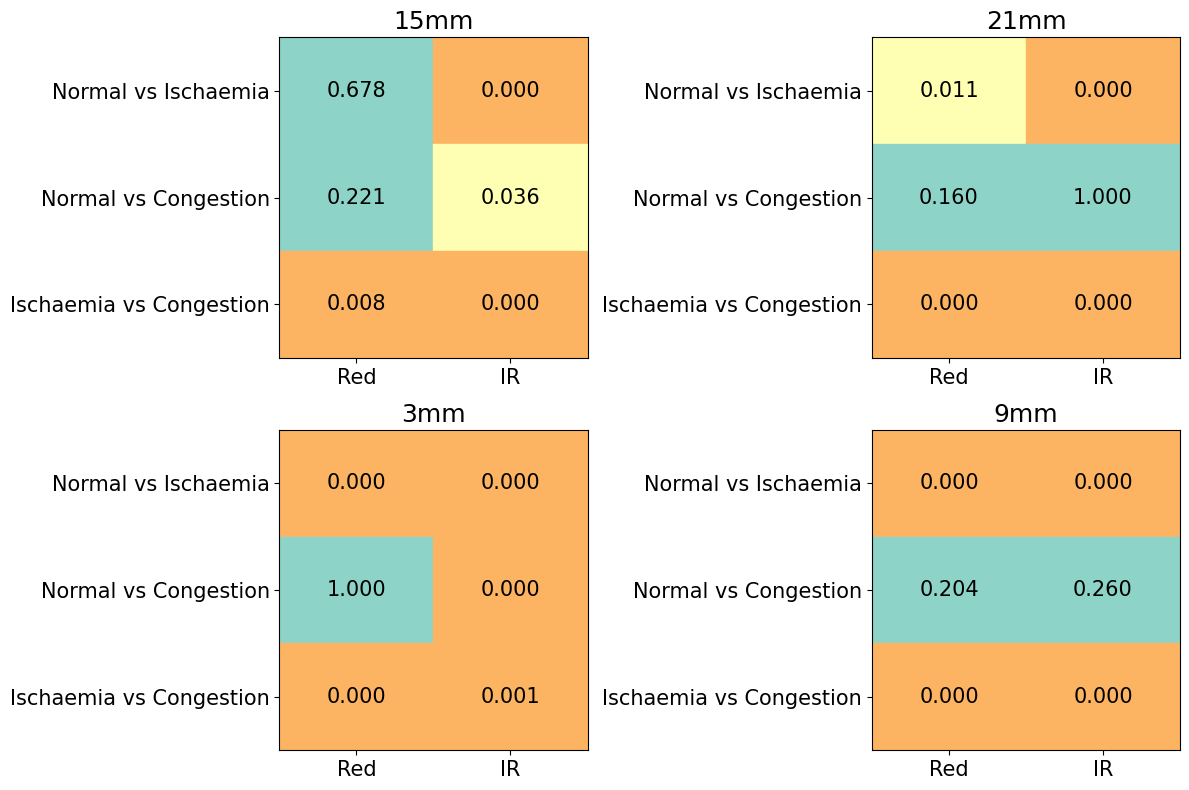

In [8]:
# 再度必要なパッケージをインポートしてコードを実行

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ファイル読み込み
df = pd.read_csv("dunn_posthoc_all_depths.csv")

# 深さごとのデータに分割
depths = df["Depth"].unique()
depths.sort()

# 比較軸とチャネルの順序を定義
comparisons = ["Normal vs Ischaemia", "Normal vs Congestion", "Ischaemia vs Congestion"]
channels = ["Red", "IR"]

# 色のマップ関数：p値に応じて色を設定
def get_color(p):
    if p < 0.01:
        return "#fdb462"  # 優しい青緑
    elif p < 0.05:
        return "#ffffb3"  # 優しい黄色
    else:
        return "#8dd3c7"  # 優しいオレンジ

# プロット準備
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, depth in enumerate(depths):
    ax = axes[idx]
    sub_df = df[df["Depth"] == depth]

    # 描画用マトリクス作成
    heatmap_data = pd.DataFrame(index=comparisons, columns=channels)

    for _, row in sub_df.iterrows():
        heatmap_data.loc[row["Comparison"], row["Channel"]] = row["p (Adjusted)"]

    # 数値のp値を float で保存し、色塗り用に用いる
    p_values = heatmap_data.astype(float)

    # 手動で heatmap 描画（p値に応じた背景色、文字重ね）
    for i, comp in enumerate(comparisons):
        for j, ch in enumerate(channels):
            p_val = p_values.loc[comp, ch]
            color = get_color(p_val)
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor='white'))
            ax.text(j + 0.5, i + 0.5, f"{p_val:.3f}", ha='center', va='center', fontsize=15)

    # 軸設定
    ax.set_xticks(np.arange(len(channels)) + 0.5)
    ax.set_yticks(np.arange(len(comparisons)) + 0.5)
    ax.set_xticklabels(channels, fontsize=15)
    ax.set_yticklabels(comparisons, fontsize=15)
    ax.set_xlim(0, len(channels))
    ax.set_ylim(0, len(comparisons))
    ax.set_title(f"{depth}", fontsize=18)
    ax.invert_yaxis()
    ax.set_aspect('auto')  # 自動で長方形化
    ax.grid(False)

plt.tight_layout()
plt.show()


/var/folders/tw/4620924j72b6x10pfhthmm5m0000gn/T/ipykernel_14609/3335437166.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlGnBu_r')


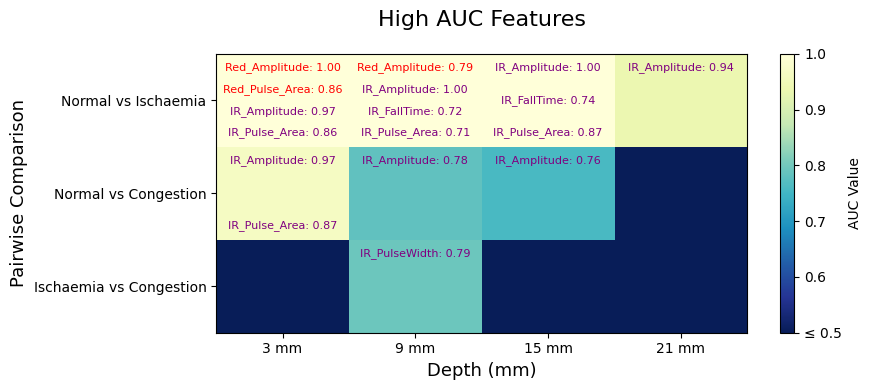

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ========= 1. データ読み込みと準備 =========

# 最終的に生成されたAUCサマリーファイル名を指定（必要に応じて変更してください）
FILE_PATH = "AUC_all_features_95CI_final_RedIRRatio.csv"
try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}. Please run the previous code block to generate the CSV.")
    exit()

# NaN値を含む行を削除し、AUC値が0.7未満のものは無視する
df_filtered = df.dropna(subset=['AUC_bootstrap_mean'])
df_filtered_plot = df_filtered[df_filtered['AUC_bootstrap_mean'] > 0.7].copy() # プロット対象（AUC>0.7）のみ

# ========= 2. 特徴量の整形と色の定義 =========

# 2.1. 特徴名のマッピングと結合
def format_feature_name(row):
    feature = row['Feature']
    channel = row['Channel']
    
    # Amp_normをAmplitudeに改名
    if feature == 'Amp_norm':
        feature = 'Amplitude'
        
    # Pulse_Area_normはPulse_Areaと同一とみなし削除（Noneを返すことでフィルタリング）
    if feature == 'Pulse_Area_norm':
        return None
        
    # ChannelとFeatureを結合 
    if channel in ['Red', 'IR']:
        return f"{channel}_{feature}"
    elif channel == 'Red/IR_Ratio':
        # Ratioの場合はFeature名をそのまま使用（例: Red_IR_amp_norm_ratio）
        return feature
    return None

df_filtered_plot['Combined_Feature'] = df_filtered_plot.apply(format_feature_name, axis=1)
df_filtered_plot = df_filtered_plot.dropna(subset=['Combined_Feature'])

# 2.2. 色の定義
def get_feature_color(feature_name):
    """Red/IRに基づいて色を決定"""
    feature_name = feature_name.lower()
    if 'red' in feature_name:
        return 'red'
    elif 'ir' in feature_name:
        return 'purple'
    return 'black'

# 2.3. ヒートマップ描画用データフレームの準備
# 縦軸のペアの順序を定義
pair_order = [
    'Normal vs Ischaemia',
    'Normal vs Congestion',
    'Ischaemia vs Congestion'
]
# 横軸のDepthの順序を定義
depth_order = sorted(df_filtered_plot['Depth'].unique())

# グリッドの各セルに表示するテキストと背景色の値を準備
text_grid = {} # key: (Pair, Depth), value: [(text, color, auc_value), ...]
heatmap_values = pd.DataFrame(index=pair_order, columns=depth_order, dtype=float)

for index, row in df_filtered_plot.iterrows():
    pair = row['Pair']
    depth = row['Depth']
    feature_name = row['Combined_Feature']
    auc_value = row['AUC_bootstrap_mean']
    
    key = (pair, depth)
    
    # テキスト準備
    text = f"{feature_name}: {auc_value:.2f}"
    color = get_feature_color(feature_name)
    
    if key not in text_grid:
        text_grid[key] = []
    text_grid[key].append((text, color, auc_value))
    
    # 背景色の基準（セル内の最大AUC）を更新
    if pair in pair_order and depth in depth_order:
        current_max = heatmap_values.loc[pair, depth]
        if pd.isna(current_max) or auc_value > current_max:
            heatmap_values.loc[pair, depth] = auc_value


# AUCが0.7未満（プロット対象外）のセルは、カラーマップの最小値（0.5）で埋める
MIN_AUC_FOR_CMAP = 0.5 
heatmap_values = heatmap_values.fillna(MIN_AUC_FOR_CMAP) 

# ========= 3. ヒートマップのプロット =========

fig, ax = plt.subplots(figsize=(9, 4)) # figsizeを少し大きく調整

# 3.1. 背景色 (AUCが高いほど明るい色、青を0.5付近に)
cmap = plt.cm.get_cmap('YlGnBu_r') 
norm = mcolors.Normalize(vmin=MIN_AUC_FOR_CMAP, vmax=1.0) 

cax = ax.imshow(heatmap_values.values, cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')

# 3.2. 軸の設定
ax.set_xticks(np.arange(len(depth_order)))
ax.set_yticks(np.arange(len(pair_order)))
ax.set_xticklabels([f'{d} mm' for d in depth_order])
ax.set_yticklabels(pair_order)

ax.set_xlabel('Depth (mm)', fontsize=13)
ax.set_ylabel('Pairwise Comparison', fontsize=13)
ax.set_title(f'High AUC Features', fontsize=16, pad=20)

# 3.3. テキストの描画
for i, pair in enumerate(pair_order):
    for j, depth in enumerate(depth_order):
        key = (pair, depth)
        
        # AUC > 0.7のデータがあるセルのみにテキストを描画
        if key in text_grid and heatmap_values.loc[pair, depth] > 0.7:
            entries = [(t, c) for t, c, a in text_grid[key]] # (text, color) のみを使用
            
            # セル内のテキスト配置を調整
            n_entries = len(entries)
            
            # 垂直方向の中心から上下にずらして配置
            y_offsets = np.linspace(-0.35, 0.35, n_entries)
            
            for k, (text, color) in enumerate(entries):
                ax.text(j, i + y_offsets[k],
                        text, 
                        ha="center", 
                        va="center", 
                        color=color, 
                        fontsize=8, 
                        linespacing=1.2)

# 3.4. カラーバーの追加と修正
cbar_ticks = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar = fig.colorbar(cax, ticks=cbar_ticks, label='AUC Value')

# Y軸のラベルを設定
custom_labels = [f'{t:.1f}' for t in cbar_ticks]
# 最小値のラベルをカスタマイズ (AUC <= 0.5)
custom_labels[0] = f'≤ {MIN_AUC_FOR_CMAP:.1f}'

# Y軸の目盛りラベルを設定（これが正しい方法）
cbar.ax.set_yticklabels(custom_labels) 

# ★ エラーの原因となっていた X軸のラベル設定を削除 ★
# cbar.ax.set_xticklabels(...) # この行を削除

plt.tight_layout()
plt.show()